In [1]:
import numpy as np
import pandas as pd
import random
import keras
import os
import datetime as dt
import pickle

import tensorflow as tf

import keras.backend as K
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Layer, Bidirectional, CuDNNGRU
from keras.layers import Convolution1D, GlobalMaxPooling1D, SpatialDropout1D ,LeakyReLU
from keras.layers import Concatenate, add, Add
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras import initializers,regularizers, constraints
from keras.utils import to_categorical

from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"]="0"


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
print(tf.__version__)
print(keras.__version__)


1.14.0
2.2.4


In [3]:
with open("fp_db.pkl","rb") as fp:
    fp_db = pickle.load(fp,encoding='latin1')
    
with open("prt_db.pkl","rb") as pr:
    prt_db = pickle.load(pr,encoding='latin1')
    
for i in range(len(fp_db)):
    fp_db.fp[i] = np.array(list(fp_db.fp[i]), dtype=int)

In [4]:
fp_db

,name,scpdb_id,fp
0,TES,1jtv_1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,FAD,4ylf_3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,SAM,3lcv_1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,ADP,4jl5_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,YM8,2ym8_1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
17587,GSI,2vh0_1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17588,ACO,3csc_1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
17589,SAH,2pch_1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
17590,BTN,4gda_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
prt_db


,scpdb_id,seq,binding
0,1jtv_1,"[ALA, ARG, THR, VAL, VAL, LEU, ILE, THR, GLY, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4ylf_3,"[MET, GLY, GLY, THR, ALA, LEU, ASN, GLU, ILE, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3lcv_1,"[ASP, ARG, ILE, ASP, GLU, ILE, GLU, ARG, ALA, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4jl5_1,"[MET, ILE, LEU, VAL, PHE, LEU, GLY, PRO, PRO, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,2ym8_1,"[ASP, TRP, ASP, LEU, VAL, GLN, THR, LEU, GLY, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...
17587,2vh0_1,"[ILE, VAL, GLY, GLY, GLN, GLU, CYS, LYS, ASP, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17588,3csc_1,"[ALA, SER, SER, THR, ASN, LEU, LYS, ASP, VAL, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17589,2pch_1,"[MET, VAL, LEU, TYR, PHE, ILE, GLY, LEU, GLY, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ..."
17590,4gda_1,"[ALA, GLU, SER, ARG, TYR, VAL, LEU, THR, GLY, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


min:  17
max:  1504


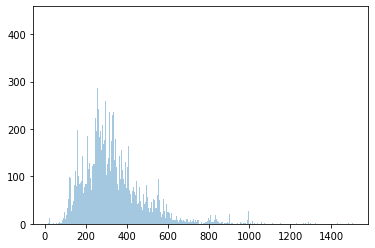

In [6]:
len_seq = [len(prt_db.seq[i]) for i in range(len(prt_db)) ]

# 단백질 시퀀스의 길이
import seaborn as sns
prt_length = [len(prt_db.seq[i]) for i in range(len(prt_db))]
hist, edges = np.histogram(prt_length, 500)

sns.distplot(prt_length, bins=500, kde=False)

print('min: ', np.min(len_seq))
print('max: ', np.max(len_seq))
AA_len = np.max(len_seq)

In [7]:
# AA_list=[]
# for i in range(len(prt_db.seq)):
#     AA_list = AA_list+list(set(prt_db.seq[i]))
    
# AA_list = set(AA_list)
# AA_list = list(AA_list)
# AA_list.sort()
# len(AA_list)
# # database에 있는 단백질 시퀀스에서 사용되는 아미노산의 종류
AA_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
       'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
       'TYR', 'VAL']
len(AA_list)

20

In [8]:
seq_dic = {w: i+1 for i,w in enumerate(AA_list)}
seq_dic

{'ALA': 1,
 'ARG': 2,
 'ASN': 3,
 'ASP': 4,
 'CYS': 5,
 'GLN': 6,
 'GLU': 7,
 'GLY': 8,
 'HIS': 9,
 'ILE': 10,
 'LEU': 11,
 'LYS': 12,
 'MET': 13,
 'PHE': 14,
 'PRO': 15,
 'SER': 16,
 'THR': 17,
 'TRP': 18,
 'TYR': 19,
 'VAL': 20}

In [9]:
prt_db.seq


0        [ALA, ARG, THR, VAL, VAL, LEU, ILE, THR, GLY, ...
1        [MET, GLY, GLY, THR, ALA, LEU, ASN, GLU, ILE, ...
2        [ASP, ARG, ILE, ASP, GLU, ILE, GLU, ARG, ALA, ...
3        [MET, ILE, LEU, VAL, PHE, LEU, GLY, PRO, PRO, ...
4        [ASP, TRP, ASP, LEU, VAL, GLN, THR, LEU, GLY, ...
                               ...                        
17587    [ILE, VAL, GLY, GLY, GLN, GLU, CYS, LYS, ASP, ...
17588    [ALA, SER, SER, THR, ASN, LEU, LYS, ASP, VAL, ...
17589    [MET, VAL, LEU, TYR, PHE, ILE, GLY, LEU, GLY, ...
17590    [ALA, GLU, SER, ARG, TYR, VAL, LEU, THR, GLY, ...
17591    [GLN, ILE, SER, VAL, ARG, GLY, LEU, ALA, GLY, ...
Name: seq, Length: 17592, dtype: object

In [10]:
def encodeSeq(seq, seq_dic):
    if pd.isnull(seq):
        return [0]
    else:
        return [seq_dic[aa] for aa in seq]
    
prt_en = pd.Series([ np.array([seq_dic[aa] for aa in prt_db.seq[i]]) for i in range(len(prt_db))])
prt_en_pad = sequence.pad_sequences(prt_en,AA_len,padding='post')
prt_en_pad
# 단백질 시퀀스 인코딩하고 패딩.

array([[ 1,  2, 17, ...,  0,  0,  0],
       [13,  8,  8, ...,  0,  0,  0],
       [ 4,  2, 10, ...,  0,  0,  0],
       ...,
       [13, 20, 11, ...,  0,  0,  0],
       [ 1,  7, 16, ...,  0,  0,  0],
       [ 6, 10, 16, ...,  0,  0,  0]], dtype=int32)

In [11]:
prt_db.binding


0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...
                               ...                        
17587    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
17588    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
17589    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...
17590    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
17591    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: binding, Length: 17592, dtype: object

In [12]:
binding_label_pad = sequence.pad_sequences(prt_db.binding,AA_len,padding='post')

In [13]:
drug_len = 1024 # 컴파운드의 피쳐수
AA_len = AA_len #1504 아미노산 인코딩 길이


learning_rate = 0.001
initializer = 'glorot_normal'
regularizer_param = 0.01
dropout = 0.2
activation = 'relu'


batch_size =  20 # 전체 라벨 수가 배수가 되어야함
epochs = 10000 #최대 

In [17]:
def dice_score(y_true, y_pred):
    smooth = 1e-08
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return loss

def dice_loss(y_true, y_pred):
    return 1 - dice_score(y_true, y_pred) + 0.1*keras.losses.binary_crossentropy(y_true, y_pred)

def tversky(y_true, y_pred):
    smooth = 1e-08
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.8
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        if self.bias:
            uit += self.b
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [18]:
def dti_model(drug_len, AA_len, initializer, regularizer_param, dropout, activation):
    
    params_dic = {"kernel_initializer": initializer,
                  "kernel_regularizer": l2(regularizer_param),
        }
    
    
    #protein target
    def prt_conv(prt_crop, filters, kernel_size, strides, activation=activation, params_dic = params_dic) : 

        prt_em = Embedding(20,20, embeddings_initializer=initializer,embeddings_regularizer=l2(regularizer_param))(prt_input)
        prt = SpatialDropout1D(0.2)(prt_em)
        
        prt1 = Convolution1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',**params_dic)(prt)
        prt = BatchNormalization()(prt1)
        prt = Activation(activation)(prt)
        prt = Convolution1D(filters=8, kernel_size=5, strides=strides, padding='same', **params_dic)(prt)
        prt = Concatenate(axis=-1)([prt, prt1])
        prt = BatchNormalization()(prt)
        prt = Activation(activation)(prt)
    
        
        #prt = GlobalMaxPooling1D()(prt)
        
        prt = Bidirectional(CuDNNGRU(128, input_shape=(AA_len,64),return_sequences=True,return_state=False))(prt)
        prt = LeakyReLU(alpha=0.3)(prt)
        prt = AttentionWithContext()(prt)
        prt = BatchNormalization()(prt)
        prt = LeakyReLU(alpha=0.3)(prt)
        
        return prt
    
    
    #compound
    def compoud_dense(cmp_input,activation=activation,dropout=dropout, params_dic = params_dic):
        
        cmp = Dense(256,**params_dic)(cmp_input) # dense BN activation Dropout 순서는.. ?
        cmp = BatchNormalization()(cmp)
        cmp = Activation(activation)(cmp)
        #cmp = Dropout(dropout)(cmp)

        cmp = Dense(128,**params_dic)(cmp)
        cmp = BatchNormalization()(cmp)
        cmp = Activation(activation)(cmp)
        #cmp = Dropout(dropout)(cmp)
        
        cmp = Dense(64,**params_dic)(cmp)
        cmp = BatchNormalization()(cmp)
        cmp = Activation(activation)(cmp)
        #cmp = Dropout(dropout)(cmp)
        
        return cmp
    


    
    cmp_input = Input(shape=(drug_len,))
    prt_input = Input(shape=(AA_len,))
    
    cmp = compoud_dense(cmp_input)
    
    prt = prt_conv(prt_input, 16, 10,1,activation,params_dic)
    
        
    
    
    # concat     
    model_t = Concatenate(axis=1)([cmp, prt])
    
    model_t = Dense(AA_len)(model_t)
    model_t = BatchNormalization()(model_t)
    model_t = Activation(activation)(model_t)
    
    model_t = Dense(AA_len)(model_t)
    model_t = BatchNormalization()(model_t)
    model_t = Activation(activation)(model_t)

    
    
    binding_site = Dense(AA_len, activation='sigmoid')(model_t)#, activity_regularizer=l2(regularizer_param))(model_t)
    #number = Dense(1, activation='sigmoid')(model_t)
   
    
    model = Model(inputs=[cmp_input,prt_input], outputs=binding_site)
    
    return model

In [19]:
model = dti_model(drug_len = drug_len,
                  AA_len = AA_len,
                  initializer =initializer,
                  regularizer_param = regularizer_param,
                  dropout = dropout,
                  activation = activation)

opt = Adam(lr=learning_rate, decay=1e-08 )
model.compile(optimizer=opt, loss=focal_tversky, metrics=['binary_accuracy', score_f1, dice_score])

#model.summary()

In [20]:
label_len =[]
for i in range(len(prt_db.binding)):
    label_len.append(len(prt_db.binding[i]))

label_len = np.asarray(label_len).reshape(len(label_len),1)


In [21]:
# binding_label_pad -> 바인딩 사이트 라벨 (패딩됨)
# prt_en_pad -> 인코딩된 시퀀스 (패딩됨)
# np.vstack(fp_db.fp.values) -> 핑거프린트 (길이 1024) 


# 6: 2 :2 ->10555 / 3518 / 3519 개로 나뉨
from sklearn.model_selection import train_test_split
cmp_train, cmp_valtest, prt_train, prt_valtest, label_train, label_valtest, z_train, z_valtest = train_test_split(
    np.vstack(fp_db.fp.values), prt_en_pad, binding_label_pad, label_len
                                        ,test_size=0.4,random_state=42)

cmp_valid, cmp_test, prt_valid, prt_test, label_valid, label_test, z_valid, z_test  = train_test_split(
    cmp_valtest, prt_valtest, label_valtest, z_valtest
                                        ,test_size=0.5,random_state=42)

In [22]:
print(len(cmp_train))
print(len(cmp_valid))
print(len(cmp_test))

10555
3518
3519


In [24]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [25]:
hist = model.fit([cmp_train,prt_train],label_train, epochs =1000, batch_size =32, validation_data=([cmp_valid,prt_valid],label_valid) , callbacks=[es,mc])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10555 samples, validate on 3518 samples
Epoch 1/1000
10555/10555 [==============================] - 34s 3ms/step - loss: 1.4791 - binary_accuracy: 0.8647 - score_f1: 0.2003 - dice_score: 0.1987 - val_loss: 0.7652 - val_binary_accuracy: 0.8944 - val_score_f1: 0.2074 - val_dice_score: 0.2074
Epoch 2/1000
10555/10555 [==============================] - 30s 3ms/step - loss: 0.7450 - binary_accuracy: 0.8755 - score_f1: 0.2050 - dice_score: 0.2049 - val_loss: 0.7363 - val_binary_accuracy: 0.8798 - val_score_f1: 0.2078 - val_dice_score: 0.2077
Epoch 3/1000
10555/10555 [==============================] - 30s 3ms/step - loss: 0.7376 - binary_accuracy: 0.8771 - score_f1: 0.2058 - dice_score: 0.2058 - val_loss: 0.7320 - val_binary_accuracy: 0.8765 - val_score_f1: 0.2046 - val_dice_score: 0.2046
Epoch 4/1000
10555/10555 [==============================] - 30s 3ms/step - loss: 0.7422 - binary_accurac

In [49]:
hist = model.fit([cmp_train,prt_train],label_train, epochs =1000, batch_size =32, validation_data=([cmp_valid,prt_valid],label_valid) , callbacks=[es,mc])

Train on 10555 samples, validate on 3518 samples
Epoch 1/1000
10555/10555 [==============================] - 34s 3ms/step - loss: 1.5719 - binary_accuracy: 0.9463 - score_f1: 0.2470 - dice_score: 0.2396 - val_loss: 0.9929 - val_binary_accuracy: 0.9770 - val_score_f1: 0.0761 - val_dice_score: 0.0834
Epoch 2/1000
10555/10555 [==============================] - 31s 3ms/step - loss: 0.7900 - binary_accuracy: 0.9565 - score_f1: 0.2752 - dice_score: 0.2692 - val_loss: 0.8917 - val_binary_accuracy: 0.9673 - val_score_f1: 0.1548 - val_dice_score: 0.1552
Epoch 3/1000
10555/10555 [==============================] - 31s 3ms/step - loss: 0.7598 - binary_accuracy: 0.9614 - score_f1: 0.2958 - dice_score: 0.2890 - val_loss: 0.8884 - val_binary_accuracy: 0.9655 - val_score_f1: 0.1728 - val_dice_score: 0.1730
Epoch 4/1000
10555/10555 [==============================] - 31s 3ms/step - loss: 0.7350 - binary_accuracy: 0.9659 - score_f1: 0.3192 - dice_score: 0.3120 - val_loss: 0.8332 - val_binary_accuracy: 0.

KeyboardInterrupt: 

In [44]:
model.load_weights('best_model.h5')

In [52]:
#from keras.utils.np_utils import to_categorical
from AudioDataGenerator import AudioDataGenerator

def data_generator(cmp, prt, label,batch_size):
    seed = 2
        
    datagen = AudioDataGenerator(
                        shift=0.1,
                        fill_mode='constant',
                        cval=0.)
                        
    
    l_ = len(cmp)
    cmp = cmp.reshape(l_, drug_len,1)
    prt = prt.reshape(l_,AA_len,1)
    label = label.reshape(l_, AA_len,1)

    
    x_gen = datagen.flow(prt, cmp, batch_size=batch_size, shuffle = True, seed = seed )
    y_gen = datagen.flow(label, batch_size=batch_size, shuffle = True, seed = seed )
   
    
    
    data_gen = zip(x_gen, y_gen)                
    for (X_ , label) in data_gen:
        cmp = X_[1]
        prt = X_[0]
        L_ = len(cmp)
        cmp = cmp.reshape(L_,drug_len)
        prt = prt.reshape(L_,AA_len)
        label = label.reshape(L_,AA_len)
        yield [cmp,prt], label




In [53]:
hist = model.fit_generator(
        data_generator(cmp_train, prt_train, label_train, batch_size=16),
        steps_per_epoch=660,
        epochs=1000,
        validation_data=data_generator(cmp_valid, prt_valid, label_valid,batch_size=16),
        validation_steps=220,
        callbacks=[es,mc])

Epoch 1/1000
660/660 [==============================] - 62s 94ms/step - loss: 1.2520 - binary_accuracy: 0.9200 - score_f1: 0.1752 - dice_score: 0.1695 - val_loss: 0.8659 - val_binary_accuracy: 0.9213 - val_score_f1: 0.1749 - val_dice_score: 0.1595
Epoch 2/1000
660/660 [==============================] - 60s 90ms/step - loss: 0.8684 - binary_accuracy: 0.9203 - score_f1: 0.1792 - dice_score: 0.1733 - val_loss: 0.8859 - val_binary_accuracy: 0.9157 - val_score_f1: 0.1810 - val_dice_score: 0.1732
Epoch 3/1000
660/660 [==============================] - 59s 90ms/step - loss: 0.8834 - binary_accuracy: 0.9231 - score_f1: 0.1822 - dice_score: 0.1764 - val_loss: 0.8778 - val_binary_accuracy: 0.9271 - val_score_f1: 0.1805 - val_dice_score: 0.1752
Epoch 4/1000
660/660 [==============================] - 60s 90ms/step - loss: 0.8768 - binary_accuracy: 0.9224 - score_f1: 0.1839 - dice_score: 0.1779 - val_loss: 0.8794 - val_binary_accuracy: 0.9086 - val_score_f1: 0.1849 - val_dice_score: 0.1800
Epoch 5/

KeyboardInterrupt: 

In [45]:
loss_and_metrics = model.evaluate([cmp_test, prt_test] , label_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)


3519/3519 [==============================] - 3s 770us/step
## evaluation loss and_metrics ##
[0.46504765700704503, 0.9763401527572809, 0.5749595871565185, 0.568580294238061]


In [46]:
a_ = model.predict( [[cmp_train[1]],[prt_train[1]]])
print('실제 : ', np.where(label_train[0]==1))
print('예측 : ', np.where(np.round(a_)[0]==1) )

실제 :  (array([ 45,  46,  47,  48,  50,  51,  55,  57,  58,  59,  61, 114, 134,
       136, 137, 138, 139, 140, 141, 144, 162, 166, 171, 173, 180, 181,
       182, 183, 185, 290, 293, 296, 298, 300]),)
예측 :  (array([56, 87, 88, 89]),)


In [47]:
b_ = model.predict(  [[cmp_test[0]],[prt_test[0]]])
print('실제 : ', np.where(label_test[1]==1))

print('예측 : ', np.where(np.round(b_)[0]==1) )

실제 :  (array([ 28,  33,  34,  35,  36,  46,  49,  50,  53, 201, 203, 204, 240,
       241, 242, 243, 244, 245]),)
예측 :  (array([ 12,  13,  17,  19,  21,  24,  43,  44,  45,  63,  66,  69,  71,
        72,  73,  90,  91,  92, 111, 115, 116, 117, 118, 119, 120, 124,
       127, 160, 161, 162, 187, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201]),)


In [2]:
pred_label = model.predict(  [cmp_test,prt_test])

NameError: name 'model' is not defined

In [3]:
predict_all = []
true_all = []
print(pred_label.shape, len(z_test))
for i in range(len(z_test)):
    pred_temp = pred_label[i][:z_test[i]]
    true_temp = label_test[i][:z_test[i]]

    for j in range(len(pred_temp)):
        predict_all.append(pred_temp[j])
        true_all.append(true_temp[j])

NameError: name 'pred_label' is not defined

In [35]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(true_all, predict_all)

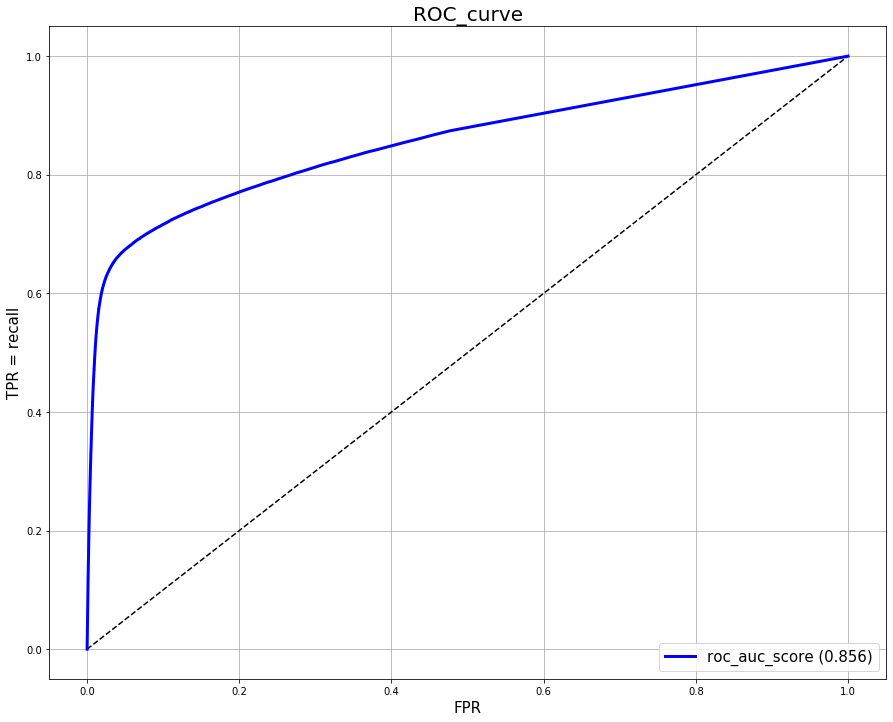

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(true_all, predict_all)

lw = 3
plt.figure(figsize=(15,12))
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.plot(fpr, tpr, lw=lw, color='b', label= 'roc_auc_score (%0.3f)' % score)

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR = recall', fontsize=15)
plt.grid()
plt.title('ROC_curve', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
#plt.savefig('./roc_'+test_name+'.png', dpi=300)

In [ ]:
a = np.array([[1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0]])
b=  np.array([[1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1]])
c=  np.array([[1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0]])
from scipy.spatial.distance import cdist

In [ ]:
print(cdist(a,b,'russellrao'))
print(cdist(a,c,'russellrao'))